# Fashion MNIST: Visión Artificial en Acción
En este trabajo se desarrolla un modelo de red neuronal convolucional (CNN) para la clasificación automática de imágenes del conjunto de datos Fashion MNIST, el cual contiene prendas de ropa representadas en escala de grises. El objetivo principal es construir un clasificador capaz de distinguir entre las diez categorías de ropa disponibles, utilizando técnicas de aprendizaje profundo. Para ello, se realiza una preparación adecuada de los datos, se construye un modelo secuencial en Keras con capas convolucionales y densas, y se evalúa su desempeño mediante métricas estándar como la precisión y el informe de clasificación. A lo largo del análisis, también se incorporan visualizaciones que permiten interpretar el comportamiento del modelo sobre ejemplos correctamente e incorrectamente clasificados. Este proyecto tiene como fin no solo alcanzar una buena tasa de acierto, sino también entender cómo las redes neuronales convolucionales procesan información visual y extraen patrones relevantes para la toma de decisiones.

## Montar Google Drive y cargar librerías

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.callbacks import TensorBoard

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Cargar y preparar el dataset Fashion-MNIST

In [2]:
# Parámetros principales
num_classes = 10
epochs = 20

# Cargar los datasets desde la carpeta "archive"
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/archive/fashion-mnist_train.csv', sep=',')
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/archive/fashion-mnist_test.csv', sep=',')

# Confirmar que los datos se cargaron
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (60000, 785)
Test shape: (10000, 785)


In [3]:
# Convertimos los DataFrames de pandas a arrays
train_data = np.array(train_df, dtype = 'float32')
test_data = np.array(test_df, dtype='float32')

In [4]:
# Separamos los datos de entrenamiento en imágenes (x) y etiquetas (y)
x_train = train_data[:, 1:] / 255  # Normalizamos los pixeles al rango [0, 1]
y_train = train_data[:, 0]

# Separamos los datos de prueba en imágenes y etiquetas, igual que con los de entrenamiento
x_test = test_data[:, 1:] / 255
y_test = test_data[:, 0]

In [5]:
# Dividimos el conjunto de entrenamiento original en un nuevo conjunto de entrenamiento y uno de validación
x_train, x_validate, y_train, y_validate = train_test_split(
    x_train, y_train, test_size=0.2, random_state=12345)

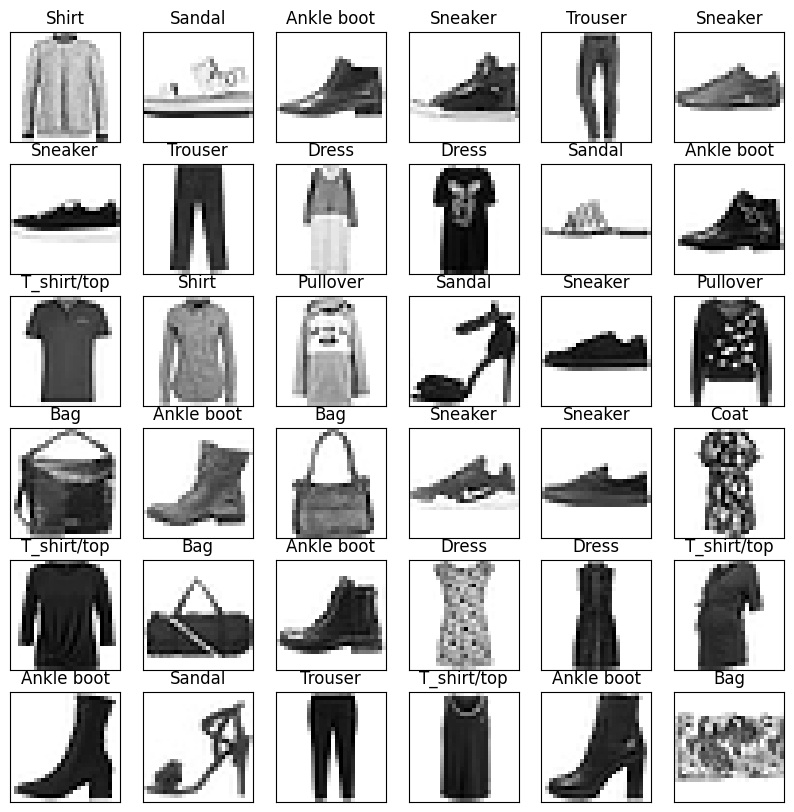

In [6]:
# Mostramos las imágenes con su clase correspondiente en formato de texto
class_names = ['T_shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(10, 10))

for i in range(36):
    plt.subplot(6, 6, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i].reshape((28, 28)), cmap=plt.cm.binary)
    label_index = int(y_train[i])
    plt.title(class_names[label_index])

plt.show()

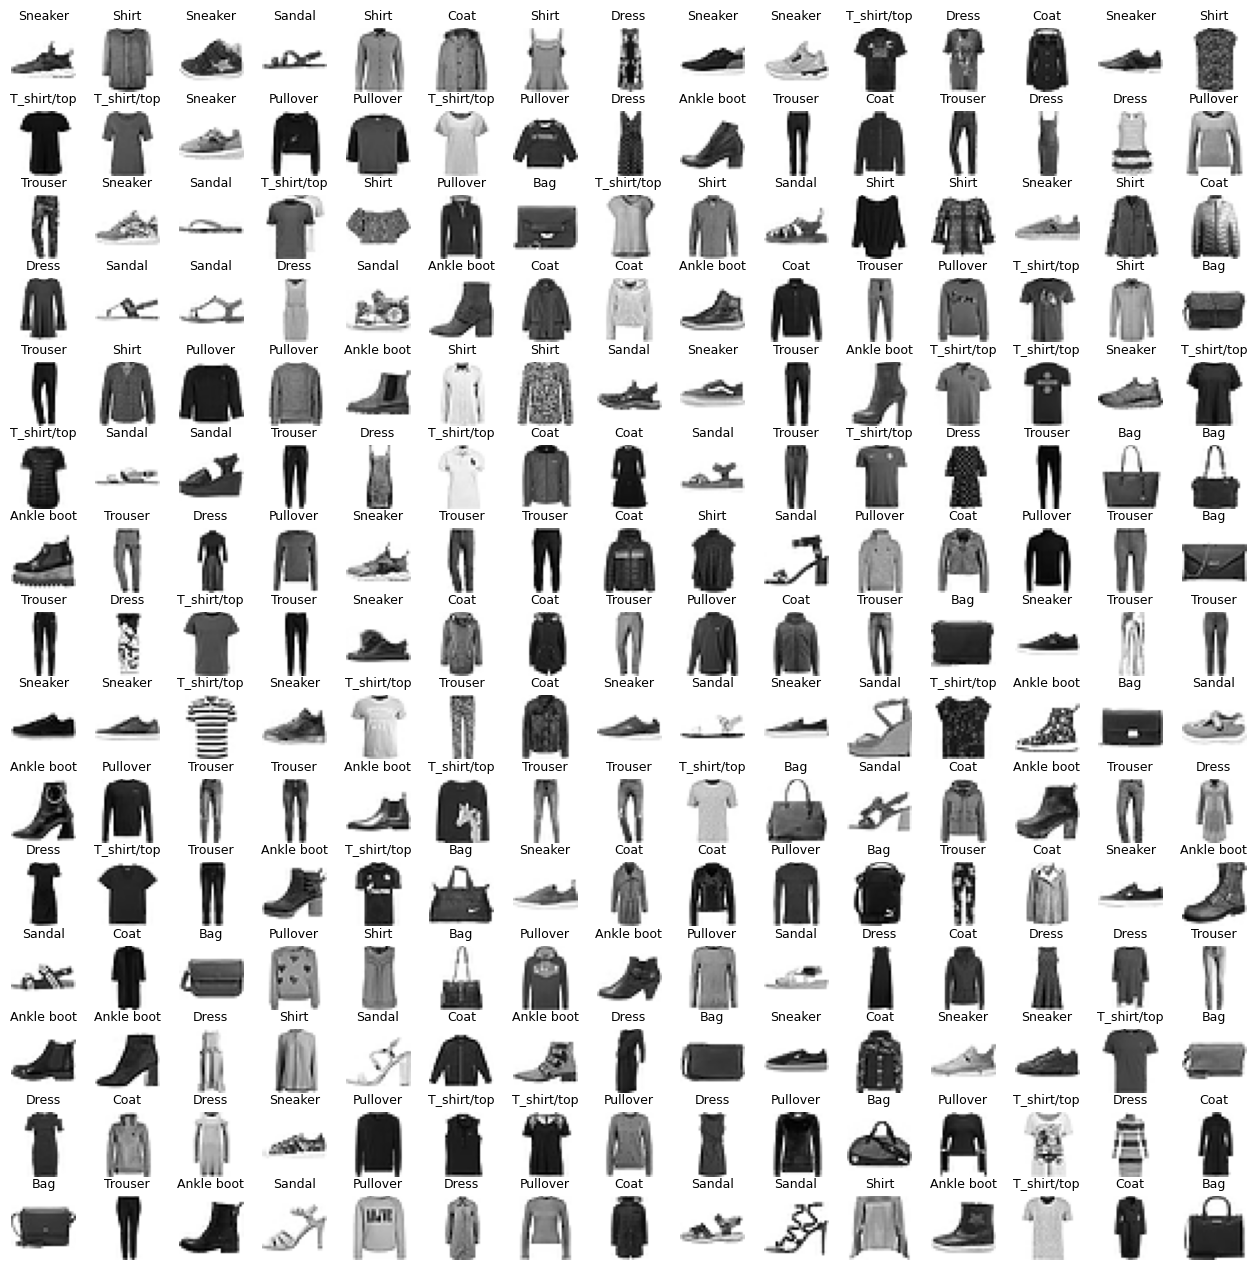

In [7]:
# Definimos una cuadrícula de imágenes para visualizar aleatoriamente ejemplos del conjunto de entrenamiento
W_grid = 15  # Número de columnas
L_grid = 15  # Número de filas

fig, axes = plt.subplots(L_grid, W_grid, figsize=(16, 16))
axes = axes.ravel()
n_train = len(train_data)  # Obtenemos la cantidad total de imágenes en el conjunto de entrenamiento

# Mostramos imágenes aleatorias de entrenamiento
for i in np.arange(0, W_grid * L_grid):  # Iteramos sobre cada espacio en la cuadrícula
    index = np.random.randint(0, n_train)  # Seleccionamos un índice aleatorio
    axes[i].imshow(train_data[index, 1:].reshape((28, 28)), cmap=plt.cm.binary)
    labelindex = int(train_data[index, 0])
    axes[i].set_title(class_names[labelindex], fontsize=9)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.3)

## Definición y entrenamiento del modelo CNN

In [8]:
# Definimos las dimensiones de la imagen
image_rows = 28
image_cols = 28
batch_size = 4096  # Tamaño del lote usado en el entrenamiento
image_shape = (image_rows, image_cols, 1)  # Forma esperada para las entradas en una CNN (3D)

# Reestructuramos los conjuntos de entrenamiento, validación y prueba
x_train = x_train.reshape(x_train.shape[0], *image_shape)
x_test = x_test.reshape(x_test.shape[0], *image_shape)
x_validate = x_validate.reshape(x_validate.shape[0], *image_shape)

In [9]:
# Definimos el modelo de red neuronal convolucional (CNN)
cnn_model = Sequential([
    # Primera capa convolucional con 32 filtros de tamaño 3x3 y función de activación ReLU
    Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=image_shape),

    # Capa de MaxPooling para reducir la dimensionalidad (de 28x28 a 14x14)
    MaxPooling2D(pool_size=2),

    # Capa de Dropout para reducir el sobreajuste (desactiva aleatoriamente el 20% de las neuronas)
    Dropout(0.2),

    # Aplanamos la salida 2D a 1D para conectar con las capas densas
    Flatten(),

    # Capa densa con 32 neuronas y ReLU como función de activación
    Dense(32, activation='relu'),

    # Capa de salida con 10 neuronas (una por cada clase) y softmax para clasificar
    Dense(10, activation='softmax')
])

In [10]:
# Compilamos el modelo antes de entrenarlo
cnn_model.compile(
    loss='sparse_categorical_crossentropy',  # Función de pérdida para clasificación multiclase con etiquetas enteras
    optimizer=Adam(learning_rate=0.001),     # Optimizador Adam con tasa de aprendizaje 0.001
    metrics=['accuracy']                     # Métrica usada para evaluar el rendimiento: exactitud
)

In [11]:
# Entrenamos el modelo con los datos de entrenamiento y validación
history = cnn_model.fit(
    x_train,              # Imágenes de entrenamiento
    y_train,              # Etiquetas correspondientes
    batch_size=4096,      # Tamaño de los lotes de datos
    epochs=50,            # Número de épocas (pasadas completas por el conjunto de entrenamiento)
    verbose=1,            # Mostrar el progreso del entrenamiento en consola
    validation_data=(x_validate, y_validate)  # Datos de validación para evaluar el modelo durante el entrenamiento
)

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 343ms/step - accuracy: 0.4102 - loss: 1.9958 - val_accuracy: 0.6873 - val_loss: 1.1232
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.7175 - loss: 0.9826 - val_accuracy: 0.7604 - val_loss: 0.6990
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.7674 - loss: 0.6710 - val_accuracy: 0.7881 - val_loss: 0.5842
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.7932 - loss: 0.5731 - val_accuracy: 0.8149 - val_loss: 0.5191
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8174 - loss: 0.5173 - val_accuracy: 0.8316 - val_loss: 0.4770
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.8336 - loss: 0.4782 - val_accuracy: 0.8413 - val_loss: 0.4496
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.8429 - loss: 0.4487 - val_accuracy: 0.8477 - val_loss: 0.4287
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.8522 - loss: 0.4302 - val_accuracy: 0.8538 - 

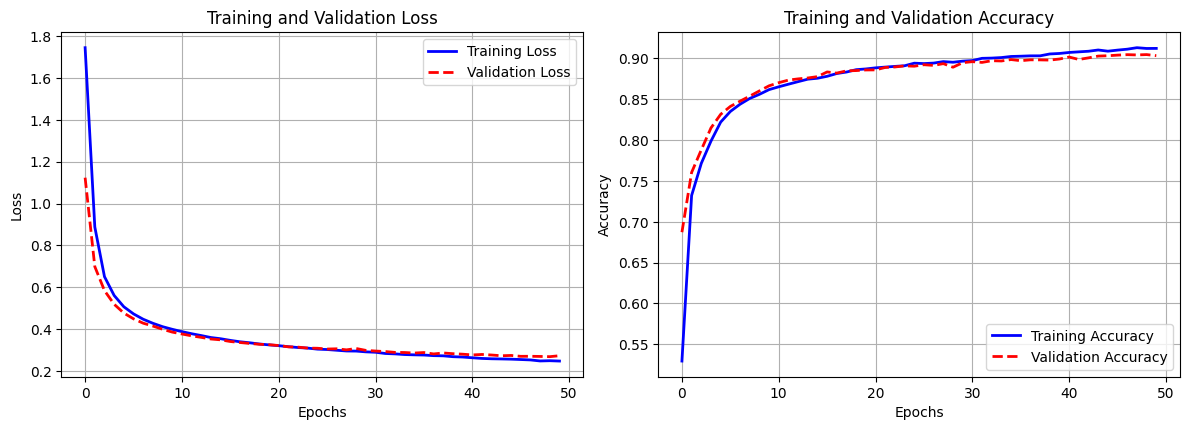

In [12]:
# Graficamos la pérdida y la exactitud del entrenamiento y validación
plt.figure(figsize=(12, 8))

# Función de pérdida
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='b', linestyle='-', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='r', linestyle='--', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Exactitud
plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='b', linestyle='-', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='r', linestyle='--', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

# Ajustar el espacio entre subgráficos
plt.tight_layout()
plt.show()

## Evaluación del modelo y visualización de métricas

In [13]:
# Evaluamos el modelo con el conjunto de prueba
score = cnn_model.evaluate(x_test, y_test, verbose=0)
print('Test Loss : {:.4f}'.format(score[0]))
print('Test Accuracy : {:.4f}'.format(score[1]))

Test Loss : 0.2749
Test Accuracy : 0.9031


## Predicción, reporte y análisis de errores

In [14]:
# Obtener las predicciones para los datos de prueba
predictions = cnn_model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas verdaderas
y_true = test_df.iloc[:, 0]

# Comparar predicciones correctas e incorrectas
correct = np.nonzero(predicted_classes == y_true)[0]
incorrect = np.nonzero(predicted_classes != y_true)[0]

# Informe de clasificación
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(y_true, predicted_classes, target_names=target_names))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

     Class 0       0.83      0.87      0.85      1000
     Class 1       0.98      0.98      0.98      1000
     Class 2       0.91      0.77      0.84      1000
     Class 3       0.92      0.92      0.92      1000
     Class 4       0.80      0.92      0.85      1000
     Class 5       0.98      0.96      0.97      1000
     Class 6       0.75      0.71      0.73      1000
     Class 7       0.95      0.95      0.95      1000
     Class 8       0.97      0.97      0.97      1000
     Class 9       0.95      0.97      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



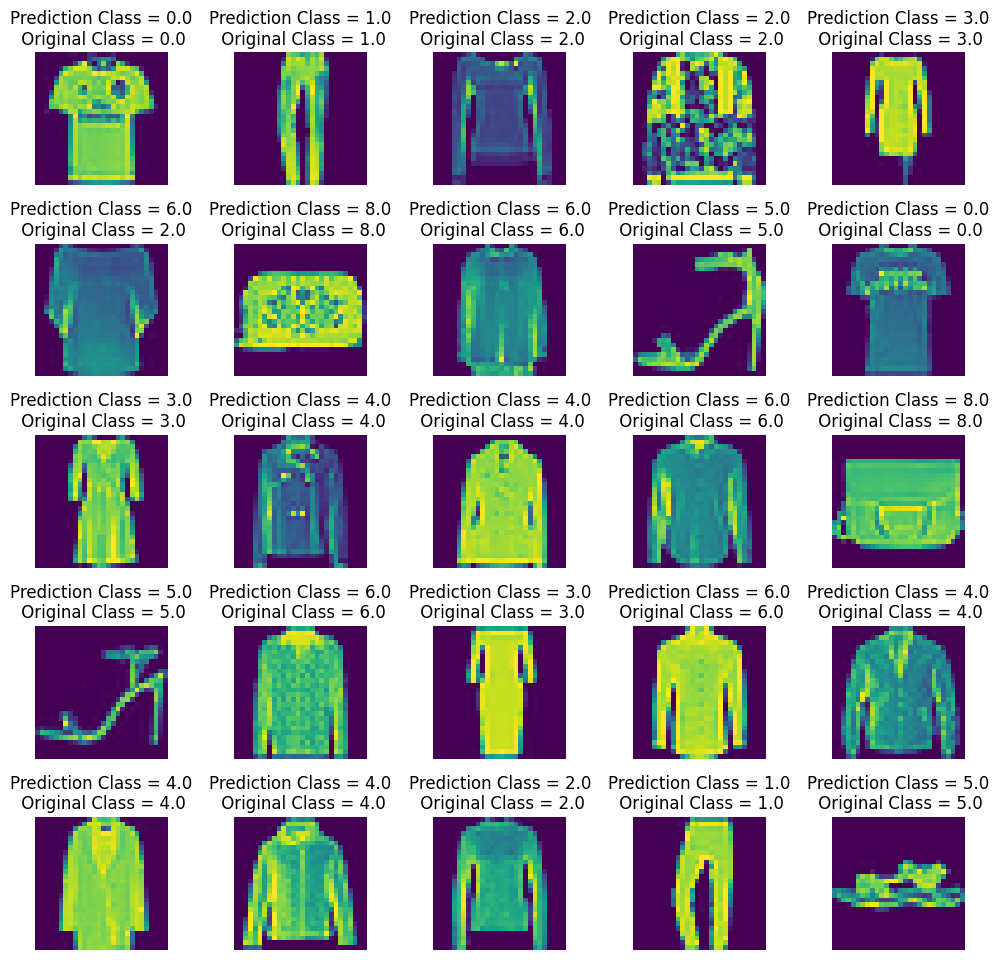

In [15]:
# Visualiza 25 imágenes del set de prueba junto con su clase predicha y real
L = 5
W = 5
fig, axes = plt.subplots(L, W, figsize = (12,12))
axes = axes.ravel()

for i in np.arange(0, L * W):
    axes[i].imshow(x_test[i].reshape(28,28))
    axes[i].set_title(f"Prediction Class = {predicted_classes[i]:0.1f}\n Original Class = {y_test[i]:0.1f}")
    axes[i].axis('off')

plt.subplots_adjust(wspace=0.5)

El modelo CNN alcanzó una impresionante precisión del 91% en el conjunto de prueba, con una pérdida de 0.2615, lo que refleja un rendimiento sólido en la clasificación de imágenes de moda. A pesar de los excelentes resultados en clases como sandalias y trajes, algunas categorías como las camisas presentaron un desempeño ligeramente inferior, lo que abre la puerta a futuras mejoras mediante ajustes finos o expansión del conjunto de datos.

Para captar las características esenciales de las imágenes, como bordes y texturas, se utilizaron 32 filtros de 3x3 en la primera capa convolucional, un enfoque que resultó eficaz para identificar patrones fundamentales. El MaxPooling permitió reducir la complejidad sin perder información importante, mientras que el Dropout se encargó de mitigar el riesgo de sobreajuste, optimizando la capacidad del modelo para generalizar a nuevos datos. Estos elementos fueron clave para lograr un modelo eficiente, equilibrado y con una alta precisión.